# 02. Neural network classification with Pytorch

Classification: predicting whether something is a category or another



## 1. Data for classification

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make a 1000 samples
n_samples = 1000
# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First five samples on X:\n {X[:5]}")
print(f"First five samples on y:\n {y[:5]}")

First five samples on X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First five samples on y:
 [1 1 1 1 0]


In [4]:
# Make a dataframe of circles data
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "Label": y
})
circles.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


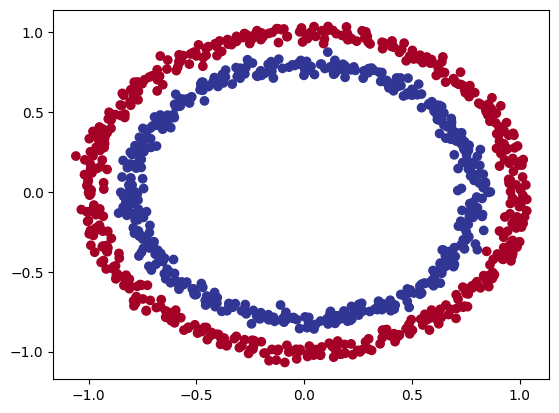

In [5]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

**Note**: the data we are working with is sometimes being refered as a toy dataset

### 1.1 Check Input and Output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and y: {y_sample}")
print(f"Values for one sample of X: {X_sample.shape} and y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and y: 1
Values for one sample of X: (2,) and y: ()


## 1.2 Get our data into tensors and create train/test splits


In [9]:
# Turn data into tensors
import torch
torch.__version__

'2.2.1+cu121'

In [10]:
type(X)

numpy.ndarray

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [13]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a Model

Let´s build a model to classify our blue/red dots.
To do so, we must:

1. Setup device agnostic code
2. Construct a model (suclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and test loops

In [15]:
# import pytorch
import torch
from torch import nn

# Make device anostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we´ve setup device agnostic code, let´s create a model that:

1. Subclasses `nn.Module` (almost all models in Pytorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass
4. Instantiate an instance of our model class and set it to the target device

In [16]:
X_train.shape

torch.Size([800, 2])

In [17]:
#1. COnstruct a model subclassing nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 NN.linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # Arbitrary value of 5
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # Same output as y shape

  # Define a forward method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer1 -> layer2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
device

'cpu'

In [19]:
next(model_0.parameters()).device

device(type='cpu')

In [20]:
# Let´s replicate model above with nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6392,  0.4950],
                      [ 0.5547,  0.0959],
                      [-0.5623,  0.6068],
                      [-0.5685,  0.1140],
                      [-0.1175, -0.6590]])),
             ('0.bias', tensor([-0.5480,  0.1038, -0.3019,  0.2876, -0.0631])),
             ('1.weight',
              tensor([[-0.3618,  0.3246,  0.3348, -0.2330, -0.3379]])),
             ('1.bias', tensor([0.4423]))])

In [22]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.]])

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1 Setup loss function and optimizer

Which loss function or optimizer to use?

Problem specific once again.

E.g. for regression you might want MAE, or MSE.

For classification you might want binary cross entropy or categorical cross entropy

And for optimizers...two of the most common are SGD and Adam but Pytorch has many more.

* For the loss function we´ll use `torch.nn.BCEWithLogitsLoss()`, for binary cross entropy (BCE).

In [23]:
# Setup loss | sigmoid activation already built-in, Sigmpid with BCELoss
loss_fn = torch.nn.BCEWithLogitsLoss()

# Setu optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr=0.1)

In [24]:
# Calculate accuracy - out of 100, % of right choices
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Training a model

To train our model, we´re oing to need a training loop.

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (SGD)

### 3.1 Going from raw logits to pred probs to prediction labels

Our model outputs are going to be **raw** logits

We can convert this **logits** into pred probabilities by passing them to some knind of activaiton function.

The we can convert these probs to prediciton labels by either raounding them or taking the `argmax()`

In [25]:
# View the fist five outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.7243],
        [0.7677],
        [0.4957],
        [0.7895],
        [0.3135]])

In [26]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [27]:
# Use the sigmoid activation function on the logits to turn them into pred probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6735],
        [0.6830],
        [0.6214],
        [0.6877],
        [0.5777]])

For our prediciton probability values, we need to performs a range-style rounding on them:

`y_pred_probs` >= 0.5, `y=1` (class 1)
`y_pred_probs` < 0.5, `y=0` (class 0)

In [28]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full logits -> pred probs -> pred labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check quality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [29]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Bulidng a training and testing loop

In [30]:
torch.manual_seed(42)

# Set the numbe of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()
  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels
  # 2. Calculate the loss / acc
  loss = loss_fn(y_logits, y_train) # loss case expects logits BCEWithLogitsLoss()
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
  # 3. Optimizer zero grad
  optimizer.zero_grad()
  # 4. Loss backward - backpropagation
  loss.backward()
  # 5. Optimizer step - GD
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate the loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred = test_pred)

    # 3. Print out what´s happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, | Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72908, | Acc: 50.00 | Test loss: 0.73417, Test acc: 50.00%
Epoch: 10 | Loss: 0.70816, | Acc: 50.00 | Test loss: 0.71523, Test acc: 50.00%
Epoch: 20 | Loss: 0.70017, | Acc: 58.13 | Test loss: 0.70755, Test acc: 55.00%
Epoch: 30 | Loss: 0.69690, | Acc: 53.37 | Test loss: 0.70400, Test acc: 50.00%
Epoch: 40 | Loss: 0.69542, | Acc: 52.12 | Test loss: 0.70204, Test acc: 48.00%
Epoch: 50 | Loss: 0.69464, | Acc: 52.12 | Test loss: 0.70075, Test acc: 49.00%
Epoch: 60 | Loss: 0.69418, | Acc: 51.75 | Test loss: 0.69978, Test acc: 47.00%
Epoch: 70 | Loss: 0.69387, | Acc: 51.62 | Test loss: 0.69901, Test acc: 47.00%
Epoch: 80 | Loss: 0.69364, | Acc: 51.25 | Test loss: 0.69837, Test acc: 46.50%
Epoch: 90 | Loss: 0.69348, | Acc: 51.38 | Test loss: 0.69784, Test acc: 47.00%


## 4. Make predictions and evaluate the model
 From the metrics, it looks model0 is guessing.
 Let´s make some predictions and make them visual

In [31]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print("already there...")
else:
  print("Downloading helper functions...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

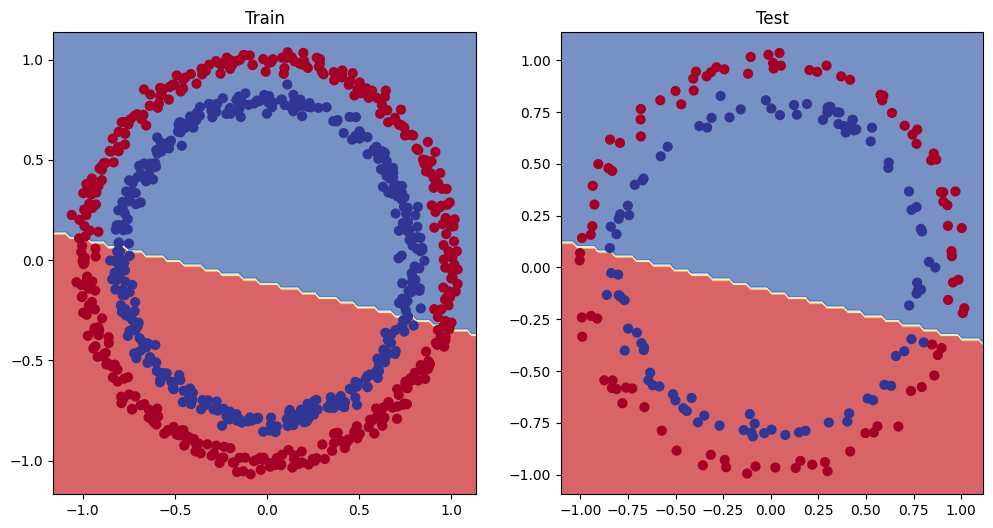

In [32]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (model perspective)

* Add more layers
* Add more hidden units - from 5 to 10
* Fit for longer
* Changing activation function
* Change the learning rate
* Change the loss function

These options are all from a model´s perspective, rather than dealing with the data.

And because these options are all values we can change, they are referred to as **hyperparameters**.

In [33]:
# Let´s try adding more hidden units (5 to 10)
# Let´s increase the number of layers
# Let´s also increase the number of epochs
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [35]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

 # Train for longer
epochs = 1000

# Put data in target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> probs -> preds

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred = y_pred)

  # 3. optimizer
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. calculate the loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}, Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0, Loss: 0.69396, Acc: 50.88, Test Loss: 0.69261, Test acc: 51.00%
Epoch: 100, Loss: 0.69305, Acc: 50.38, Test Loss: 0.69379, Test acc: 48.00%
Epoch: 200, Loss: 0.69299, Acc: 51.12, Test Loss: 0.69437, Test acc: 46.00%
Epoch: 300, Loss: 0.69298, Acc: 51.62, Test Loss: 0.69458, Test acc: 45.00%
Epoch: 400, Loss: 0.69298, Acc: 51.12, Test Loss: 0.69465, Test acc: 46.00%
Epoch: 500, Loss: 0.69298, Acc: 51.00, Test Loss: 0.69467, Test acc: 46.00%
Epoch: 600, Loss: 0.69298, Acc: 51.00, Test Loss: 0.69468, Test acc: 46.00%
Epoch: 700, Loss: 0.69298, Acc: 51.00, Test Loss: 0.69468, Test acc: 46.00%
Epoch: 800, Loss: 0.69298, Acc: 51.00, Test Loss: 0.69468, Test acc: 46.00%
Epoch: 900, Loss: 0.69298, Acc: 51.00, Test Loss: 0.69468, Test acc: 46.00%


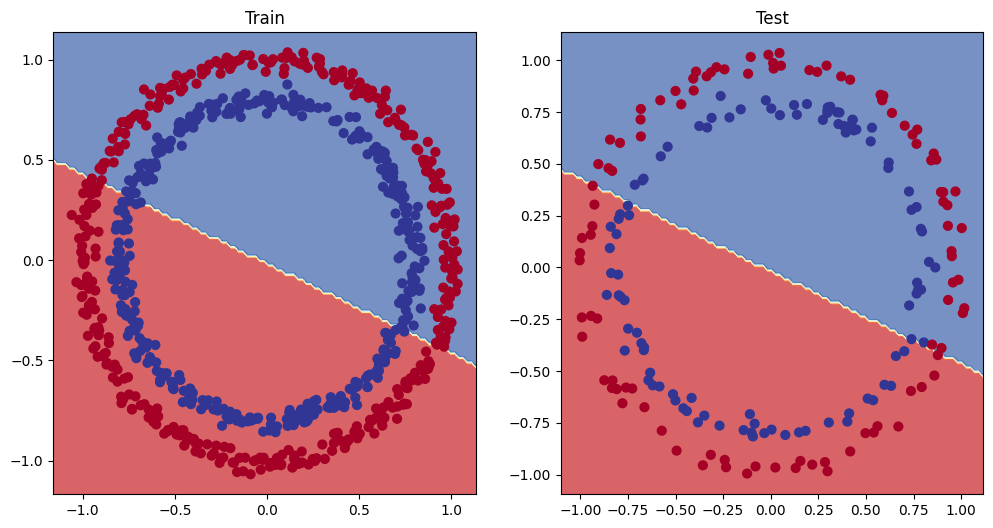

In [36]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)


### 5.1 preparing data to fit a straight line

One way to troubleshoot a larger problem is to test put a smaller problem.

In [37]:
# Create some data (as 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [38]:
# Create train/test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

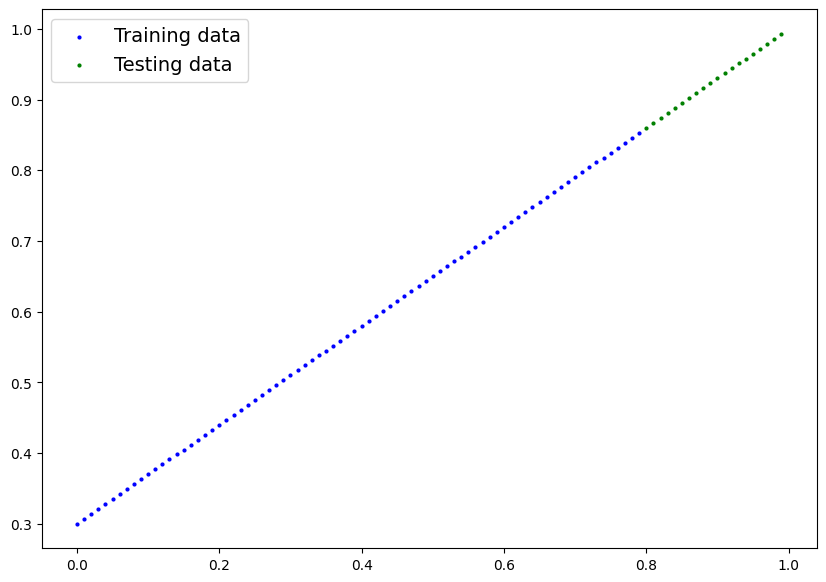

In [39]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [40]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

### 5.2 Adjusting model_1 to fit a straight line


In [41]:
# Same architecture as model_1 but Sequential
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)

).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [42]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [43]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)


# Train
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, loss: {loss:.5f}, Test Loss: {test_loss:.5f}")


Epoch: 0, loss: 0.75986, Test Loss: 0.91103
Epoch: 100, loss: 0.02858, Test Loss: 0.00081
Epoch: 200, loss: 0.02533, Test Loss: 0.00209
Epoch: 300, loss: 0.02137, Test Loss: 0.00305
Epoch: 400, loss: 0.01964, Test Loss: 0.00341
Epoch: 500, loss: 0.01940, Test Loss: 0.00387
Epoch: 600, loss: 0.01903, Test Loss: 0.00379
Epoch: 700, loss: 0.01878, Test Loss: 0.00381
Epoch: 800, loss: 0.01840, Test Loss: 0.00329
Epoch: 900, loss: 0.01798, Test Loss: 0.00360


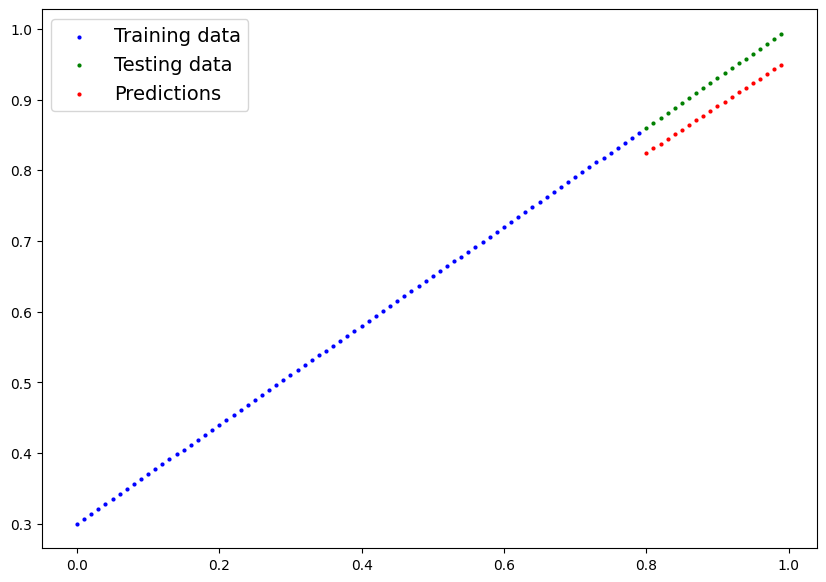

In [44]:
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# plot the data and prediciotns
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing pice: non-linearity

What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?

*- linear and non linear functions (ML)*

ANN are a large combination of straight and non-straight functions to find patterns in data

### 6.1 Recreating non-linear data (red and blue circles)


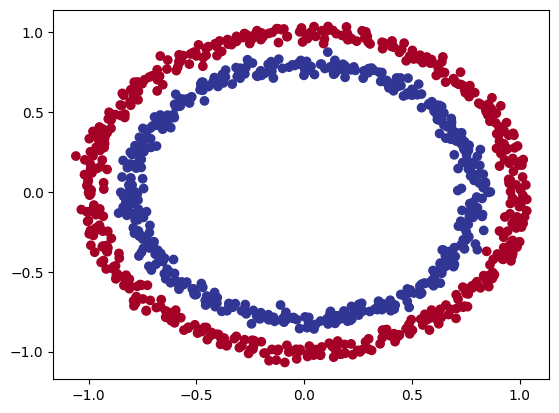

In [45]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [46]:
# Splitting into training and testing and turning into tensors
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [47]:
### 6.2 Building a model with non-linearity

from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    # We´ll put a relu function in between
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [48]:
# Building an optimzer and a loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),lr=0.1)

### 6.3 Training a model with non-linearity



In [49]:
# Random seed
torch.manual_seed(42)
#torch.cuda.manual_seed(42)

# Put all data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  # Training
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> probs -> labels
  loss = loss_fn(y_logits, y_train) # BCEWL logist as first input
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits=model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  #Print out whats happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

Epoch: 0, | Loss: 0.6929, Acc: 50.00% | Test Loss: 0.6932 | Test Acc: 50.00%
Epoch: 100, | Loss: 0.6912, Acc: 52.88% | Test Loss: 0.6910 | Test Acc: 52.50%
Epoch: 200, | Loss: 0.6898, Acc: 53.37% | Test Loss: 0.6894 | Test Acc: 55.00%
Epoch: 300, | Loss: 0.6879, Acc: 53.00% | Test Loss: 0.6872 | Test Acc: 56.00%
Epoch: 400, | Loss: 0.6852, Acc: 52.75% | Test Loss: 0.6841 | Test Acc: 56.50%
Epoch: 500, | Loss: 0.6810, Acc: 52.75% | Test Loss: 0.6794 | Test Acc: 56.50%
Epoch: 600, | Loss: 0.6751, Acc: 54.50% | Test Loss: 0.6729 | Test Acc: 56.00%
Epoch: 700, | Loss: 0.6666, Acc: 58.38% | Test Loss: 0.6632 | Test Acc: 59.00%
Epoch: 800, | Loss: 0.6516, Acc: 64.00% | Test Loss: 0.6476 | Test Acc: 67.50%
Epoch: 900, | Loss: 0.6236, Acc: 74.00% | Test Loss: 0.6215 | Test Acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions


In [50]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

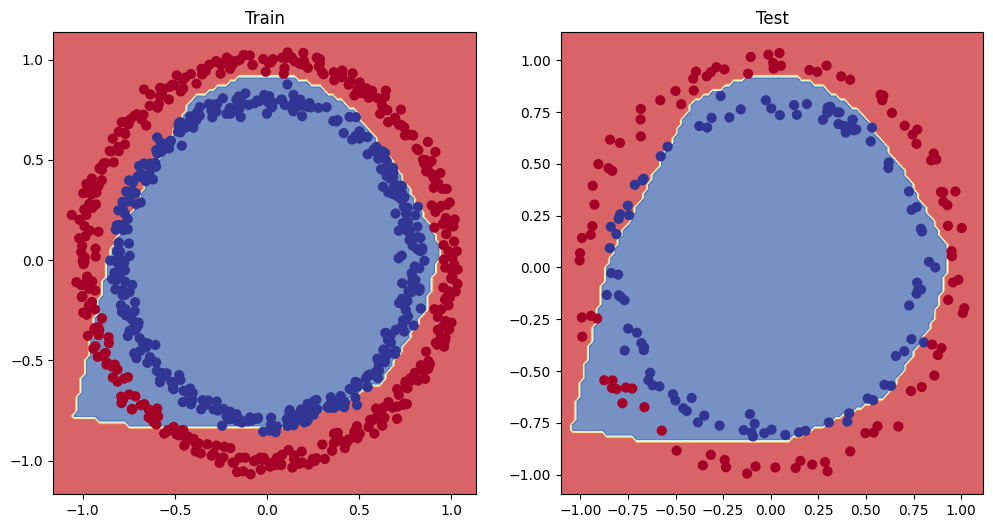

In [51]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

In [52]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [53]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

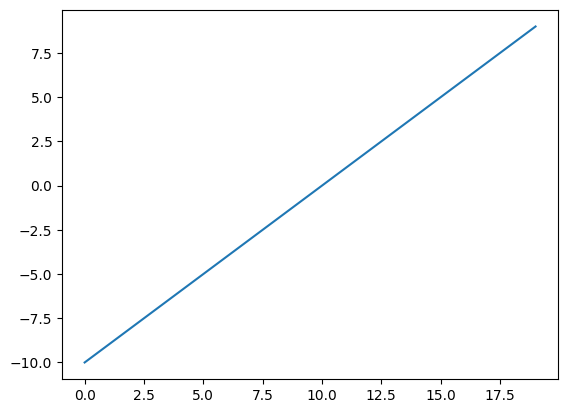

In [54]:
# Visualize the tensor
plt.plot(A)

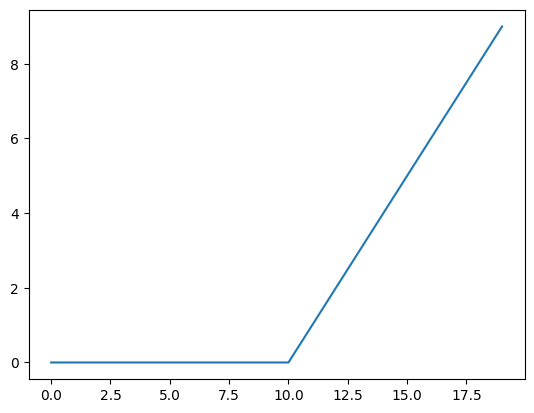

In [55]:
plt.plot(torch.relu(A));

In [56]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x) # Inputs must be tensor

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

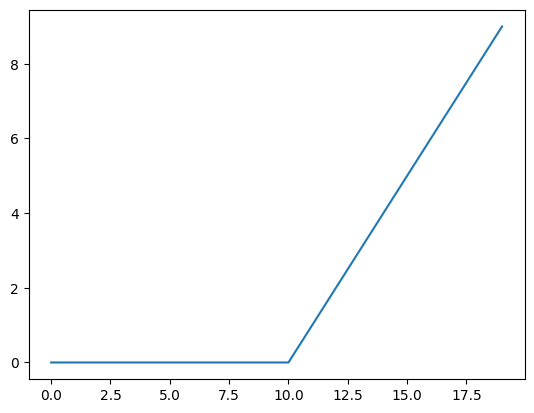

In [57]:
# Plot ReLu actiation function
plt.plot(relu(A));

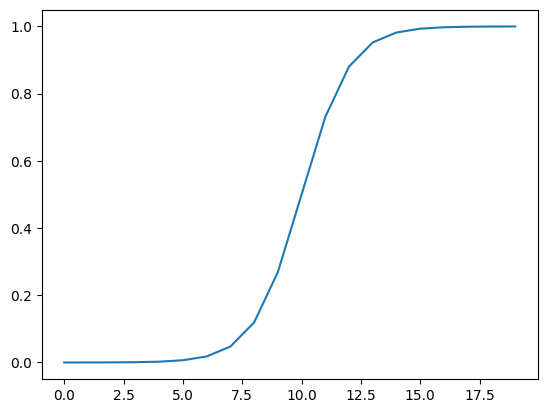

In [58]:
# Sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(A));

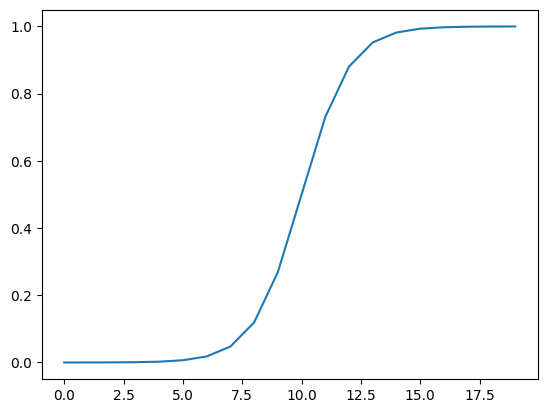

In [59]:
plt.plot(torch.sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification - one or another
* Multiclass classification - more than one thing vs another one


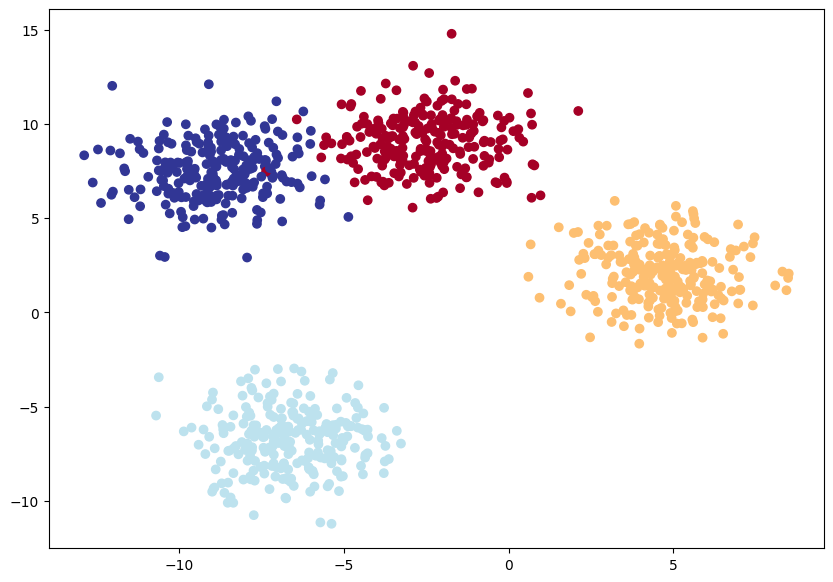

In [87]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multiclass data
X_blob , y_blob = make_blobs(n_samples=1000,
                            n_features = NUM_FEATURES,
                            centers= NUM_CLASSES,
                            cluster_std=1.5, # Give the clusters a little chake
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.20, random_state=RANDOM_SEED)

# Get visuals
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in Pytorch

In [88]:
# Creating device agnostic code
device = "cuda" if torch.cuda.is_available() else 'cpu'
device


'cpu'

In [89]:
# Building a multiclass classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes multiclass classification model
    Args:
    input_features (int): Number of input features
    output_features (int): Number of output features or output classes
    hidden_units (int): Number of hidden units between layers, default 8
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance and send it to target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multiclass classification model


In [90]:
# Setting up loss function
loss_fn = nn.CrossEntropyLoss()
# Setting up an optimizer for multi class
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

### 8.4 Getting predictions probabilities for a multi-class Pytorch model

In order to train, test our model, we need to convert our model's logits to predictins probs to pred labels


Logits (raw outputs) -> Pred probs (use `torch.softmax()`) -> Pred labels (take the argmax of the pred probs)

In [91]:
# Let´s get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[ 0.7111, -0.5330,  0.3307, -0.2327],
        [-0.3420, -1.7850, -0.3224, -1.1384],
        [ 0.1878, -0.8563,  0.3375, -0.9026],
        [ 0.4513, -0.4277,  0.2498, -0.1940],
        [ 0.8922, -0.9492,  0.3245, -0.5287],
        [-0.4885, -2.0119, -0.4004, -1.3252],
        [ 0.2586, -0.8477,  0.2739, -0.8695],
        [ 0.6816, -1.1144,  0.2053, -0.6434],
        [ 0.3433, -1.0156,  0.4706, -1.1226],
        [ 0.7687, -1.0243,  0.2629, -0.5887]])

In [92]:
# COnvert our model logist to pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.7111, -0.5330,  0.3307, -0.2327],
        [-0.3420, -1.7850, -0.3224, -1.1384],
        [ 0.1878, -0.8563,  0.3375, -0.9026],
        [ 0.4513, -0.4277,  0.2498, -0.1940],
        [ 0.8922, -0.9492,  0.3245, -0.5287]])
tensor([[0.4236, 0.1221, 0.2895, 0.1648],
        [0.3694, 0.0873, 0.3767, 0.1666],
        [0.3509, 0.1235, 0.4076, 0.1179],
        [0.3627, 0.1506, 0.2965, 0.1902],
        [0.5084, 0.0806, 0.2882, 0.1228]])


In [93]:
# Convert our models probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds = y_preds.to(float)
y_preds

tensor([0., 2., 2., 0., 0., 2., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 2.,
        0., 2., 0., 0., 0., 2., 2., 2., 2., 0., 0., 0., 2., 0., 0., 2., 0., 2.,
        0., 2., 0., 2., 0., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        2., 2., 0., 0., 2., 2., 2., 0., 2., 2., 2., 0., 0., 0., 2., 0., 0., 0.,
        2., 0., 2., 2., 2., 0., 0., 0., 0., 2., 0., 2., 2., 2., 2., 2., 2., 2.,
        0., 2., 0., 2., 2., 2., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0.,
        0., 2., 0., 0., 0., 2., 2., 0., 0., 0., 0., 2., 2., 2., 0., 0., 2., 0.,
        0., 0., 2., 2., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2.,
        2., 2., 0., 0., 0., 2., 2., 0., 2., 2., 0., 0., 0., 0., 2., 0., 2., 0.,
        2., 2., 0., 2., 2., 0., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
        0., 2., 2., 0., 2., 2., 0., 0., 2., 2., 0., 0., 0., 2., 2., 0., 2., 0.,
        2., 0.], dtype=torch.float64)

In [94]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Create a training loop and testing loop for multiclass pytorch model

In [95]:
# Fit the multiclass model to the data
torch.manual_seed(42)
#torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data in device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss=loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    # Whats happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, Loss {loss:.4f}, Acc: {acc:.2f}, Test Loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")


Epoch: 0, Loss 1.3748, Acc: 49.38, Test Loss: 1.1456, Test acc: 76.50%
Epoch: 10, Loss 0.6651, Acc: 72.62, Test Loss: 0.5592, Test acc: 79.50%
Epoch: 20, Loss 0.5013, Acc: 73.12, Test Loss: 0.4166, Test acc: 79.00%
Epoch: 30, Loss 0.4091, Acc: 80.75, Test Loss: 0.3375, Test acc: 84.00%
Epoch: 40, Loss 0.3391, Acc: 87.00, Test Loss: 0.2788, Test acc: 90.00%
Epoch: 50, Loss 0.2629, Acc: 94.88, Test Loss: 0.2129, Test acc: 97.00%
Epoch: 60, Loss 0.1630, Acc: 98.38, Test Loss: 0.1301, Test acc: 99.00%
Epoch: 70, Loss 0.0966, Acc: 98.88, Test Loss: 0.0774, Test acc: 99.00%
Epoch: 80, Loss 0.0681, Acc: 98.88, Test Loss: 0.0547, Test acc: 99.00%
Epoch: 90, Loss 0.0549, Acc: 98.88, Test Loss: 0.0440, Test acc: 99.00%


## 8.6 Making and evaluating predictions with a Pytorch multiclass model


In [97]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[ 0.9988,  4.9449, -2.3442, -0.9238],
        [-1.5220, -6.5819, -8.1528,  3.7136],
        [-3.8011, -3.0290,  5.1995, -2.5184],
        [-0.1409,  3.5777, -1.3611, -0.3910],
        [ 6.0244,  2.6601, -5.1481, -1.9724],
        [-2.2247, -8.1695, -9.5303,  4.6788],
        [-3.5962, -2.8465,  4.8426, -2.3268],
        [ 5.0665, -0.2089, -6.0726, -0.7773],
        [-4.3616, -3.6295,  6.2815, -3.1414],
        [ 5.3172,  0.8219, -5.6387, -1.1980]])

In [98]:
# Logits to pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.8898e-02, 9.7767e-01, 6.6766e-04, 2.7632e-03],
        [5.2952e-03, 3.3604e-05, 6.9853e-06, 9.9466e-01],
        [1.2323e-04, 2.6672e-04, 9.9917e-01, 4.4439e-04],
        [2.3105e-02, 9.5208e-01, 6.8199e-03, 1.7993e-02],
        [9.6624e-01, 3.3418e-02, 1.3581e-05, 3.2516e-04],
        [1.0033e-03, 2.6281e-06, 6.7393e-07, 9.9899e-01],
        [2.1600e-04, 4.5710e-04, 9.9856e-01, 7.6868e-04],
        [9.9204e-01, 5.0754e-03, 1.4417e-05, 2.8748e-03],
        [2.3862e-05, 4.9617e-05, 9.9985e-01, 8.0838e-05],
        [9.8750e-01, 1.1022e-02, 1.7237e-05, 1.4623e-03]])

In [99]:
# pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

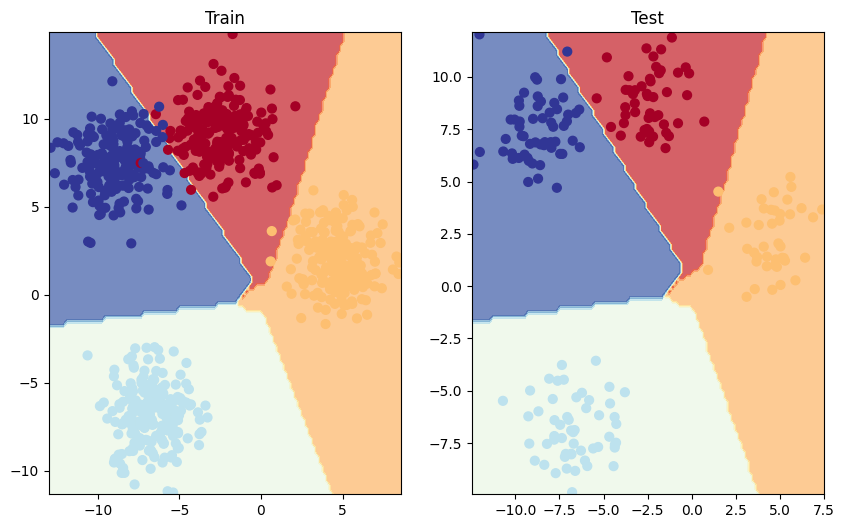

In [100]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9 A few more Classification metrics

* Accuracy
* Precision
* Recall
* F1-Score
* Confusion matrix
* Classification report

https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

see TorchMetrics

In [101]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 450.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [105]:
from torchmetrics import Accuracy
# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9900)